In [1]:


%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch 
import numpy as np
from PIL import Image
from torchvision import transforms
import pandas as pd 
import json 
import copy 
import pickle 
import os 
import sys
import copy
import umap
import wandb
from pytorch_lightning.loggers import WandbLogger

import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
sys.path.append('../py_scripts')
from py_scripts import LightningDataModule, get_params_net_dataloader
import glob
import pickle
import torch.nn.functional as F
from diffusion_utils import *

# DONT NEED TO USE GPU HERE

use_gpu = False

if use_gpu: 
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else: 
    device="cpu"



In [2]:
#!ls ../../scratch_link/Foundational-SDM/wandb_Logger/

Noise amount: 0.1
Checkpoints found ['../../scratch_link/Foundational-SDM/wandb_Logger/0.1Interpretable_NoCosine_Adam_lr0.0001_datas=None_10000Neurons_projM=False_nlayers1/version_None/checkpoints/epoch=999-step=49000.ckpt']
Load from checkpoint ../../scratch_link/Foundational-SDM/wandb_Logger/0.1Interpretable_NoCosine_Adam_lr0.0001_datas=None_10000Neurons_projM=False_nlayers1/version_None/checkpoints/epoch=999-step=49000.ckpt /home/tbricken/SDM-Diffusion/notebooks
activity threshold is: 0.0
FFN_DIFFUSION(
  (net): Sequential(
    (0): NoiseLayer()
    (1): TrackedMLPLayer(
      (act_func): ReLU()
      (layer): Linear(in_features=3072, out_features=10000, bias=True)
    )
    (2): ReLU()
    (3): Linear(in_features=10000, out_features=3072, bias=True)
  )
  (noise_layer): NoiseLayer()
)


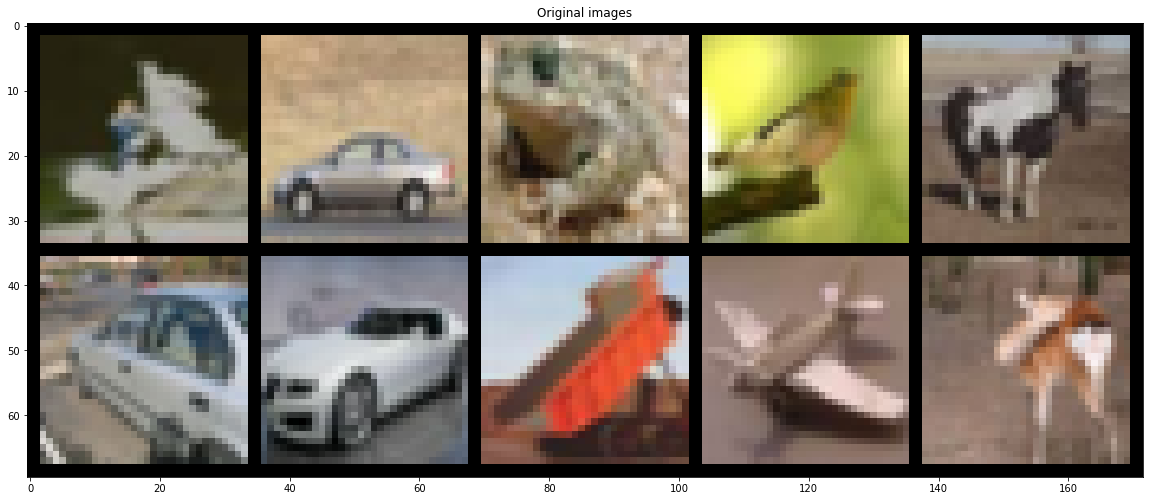

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


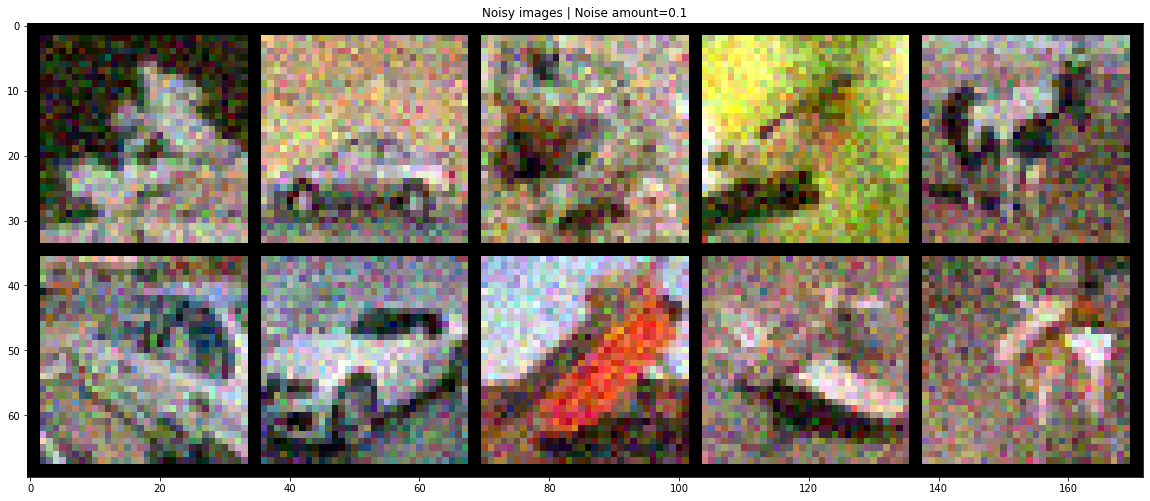

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


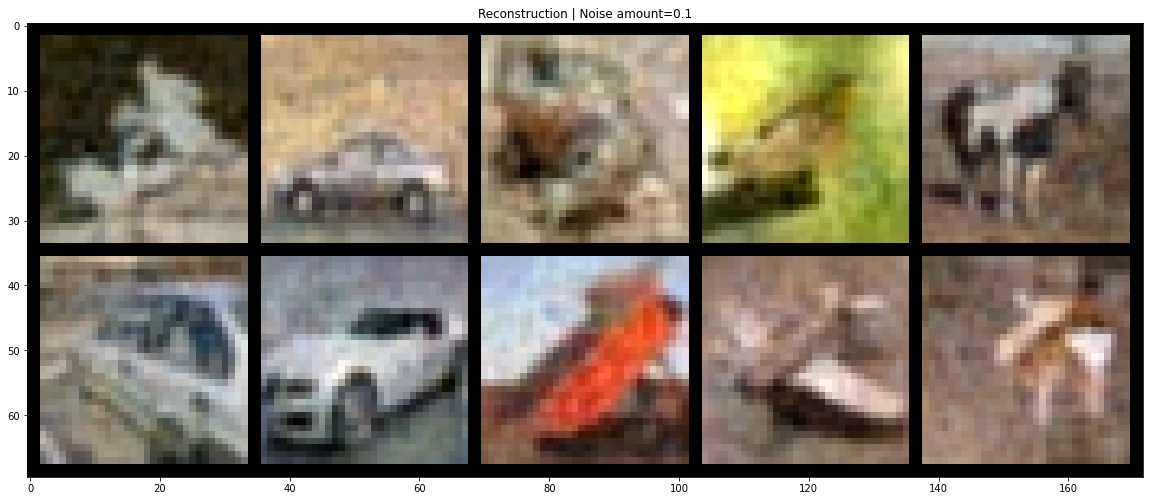

Noise amount: 0.3
Checkpoints found ['../../scratch_link/Foundational-SDM/wandb_Logger/0.3Interpretable_NoCosine_Adam_lr0.0001_datas=None_10000Neurons_projM=False_nlayers1/version_None/checkpoints/epoch=999-step=49000.ckpt']
Load from checkpoint ../../scratch_link/Foundational-SDM/wandb_Logger/0.3Interpretable_NoCosine_Adam_lr0.0001_datas=None_10000Neurons_projM=False_nlayers1/version_None/checkpoints/epoch=999-step=49000.ckpt /home/tbricken/SDM-Diffusion/notebooks
activity threshold is: 0.0


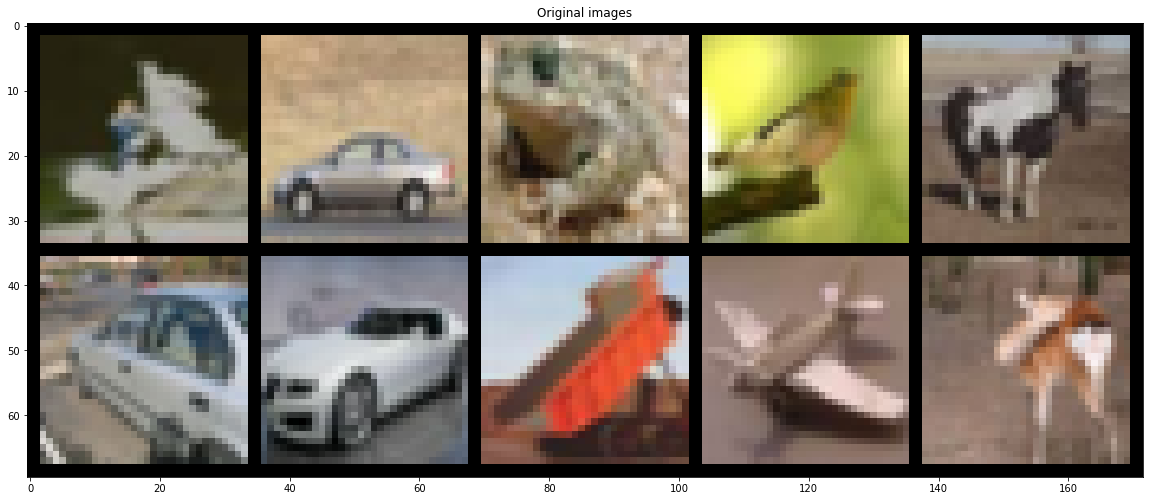

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


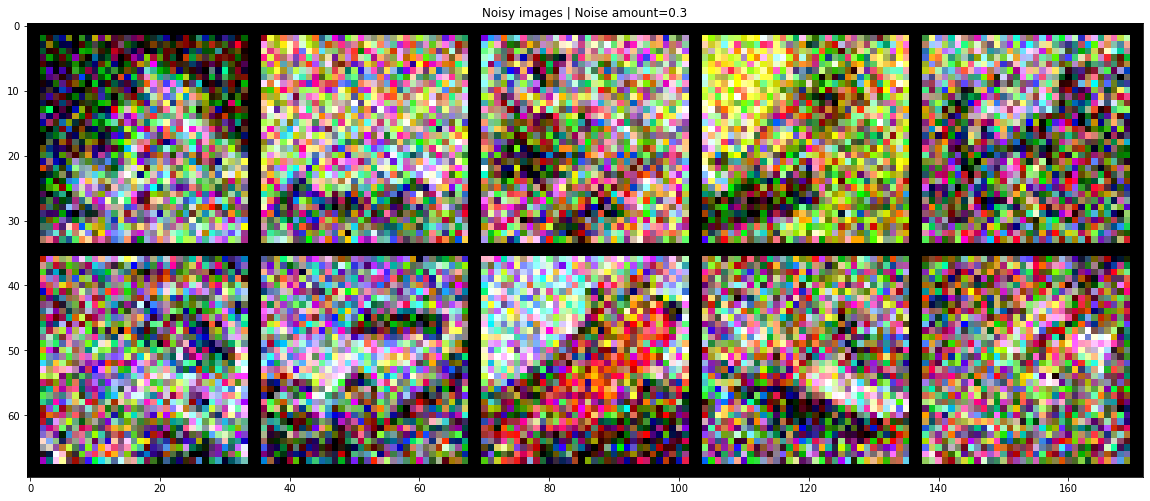

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


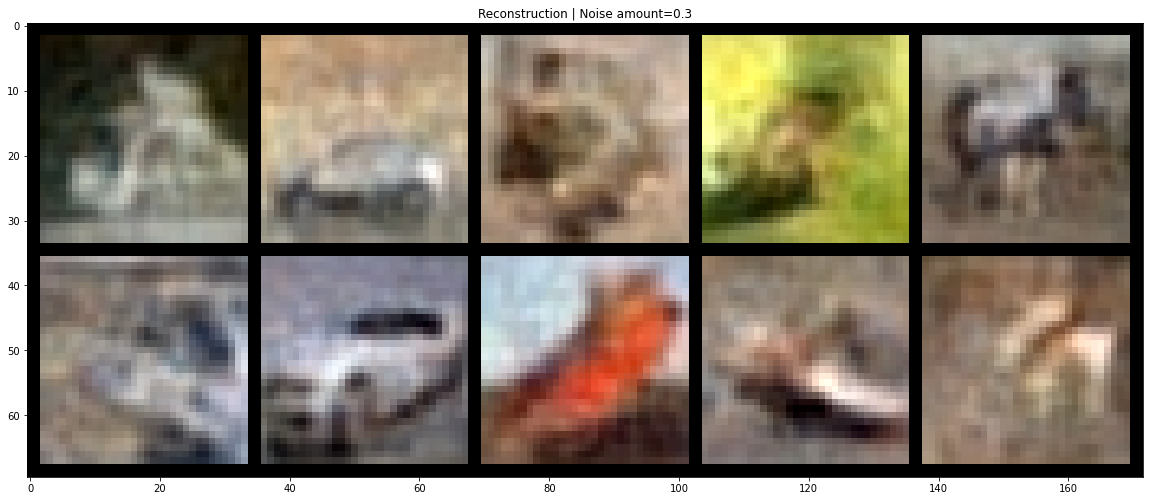

Noise amount: 0.8
Checkpoints found ['../../scratch_link/Foundational-SDM/wandb_Logger/0.8Interpretable_NoCosine_Adam_lr0.0001_datas=None_10000Neurons_projM=False_nlayers1/version_None/checkpoints/epoch=999-step=49000.ckpt']
Load from checkpoint ../../scratch_link/Foundational-SDM/wandb_Logger/0.8Interpretable_NoCosine_Adam_lr0.0001_datas=None_10000Neurons_projM=False_nlayers1/version_None/checkpoints/epoch=999-step=49000.ckpt /home/tbricken/SDM-Diffusion/notebooks
activity threshold is: 0.0


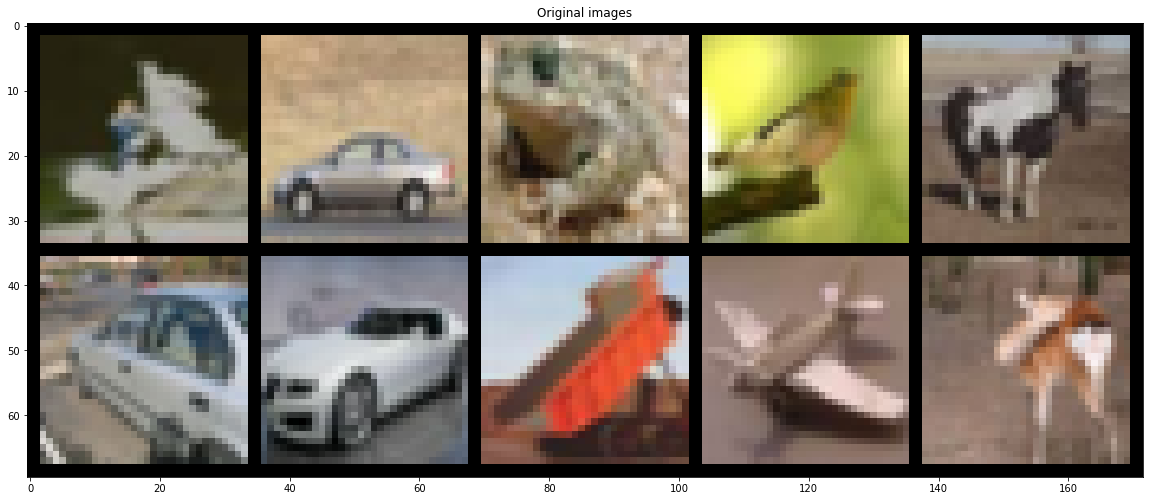

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


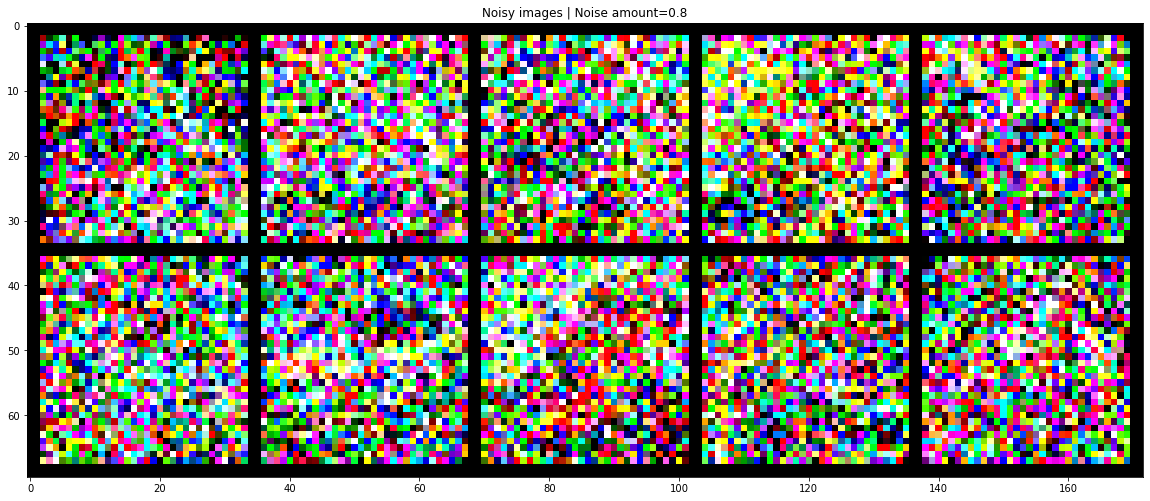

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


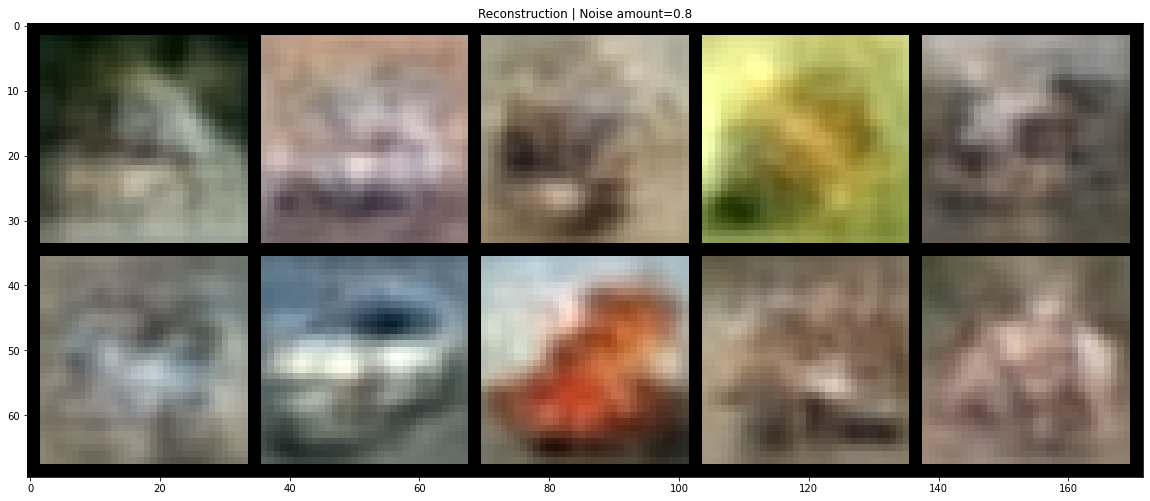

Noise amount: 1.5
Checkpoints found ['../../scratch_link/Foundational-SDM/wandb_Logger/1.5Interpretable_NoCosine_Adam_lr0.0001_datas=None_10000Neurons_projM=False_nlayers1/version_None/checkpoints/epoch=999-step=49000.ckpt']
Load from checkpoint ../../scratch_link/Foundational-SDM/wandb_Logger/1.5Interpretable_NoCosine_Adam_lr0.0001_datas=None_10000Neurons_projM=False_nlayers1/version_None/checkpoints/epoch=999-step=49000.ckpt /home/tbricken/SDM-Diffusion/notebooks
activity threshold is: 0.0


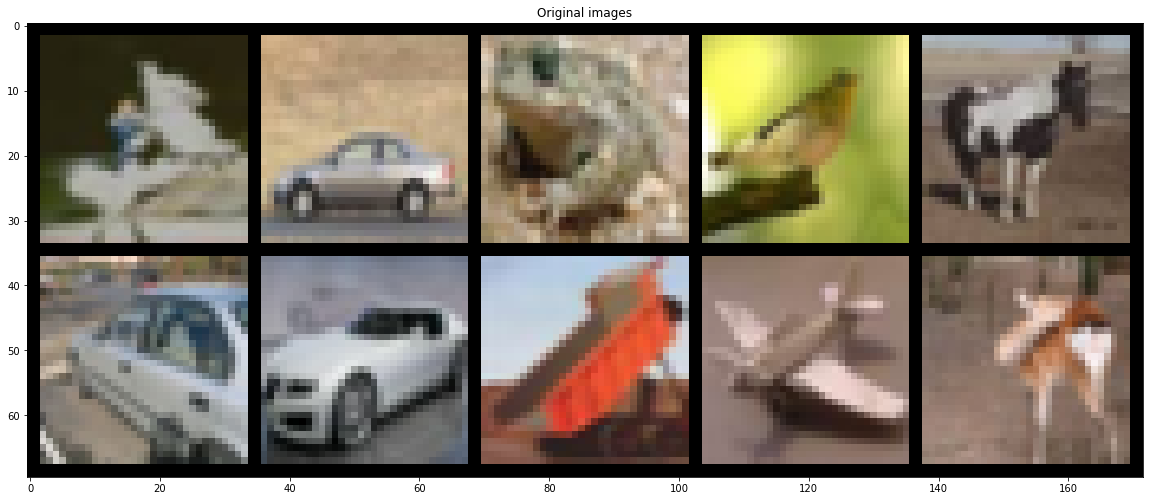

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


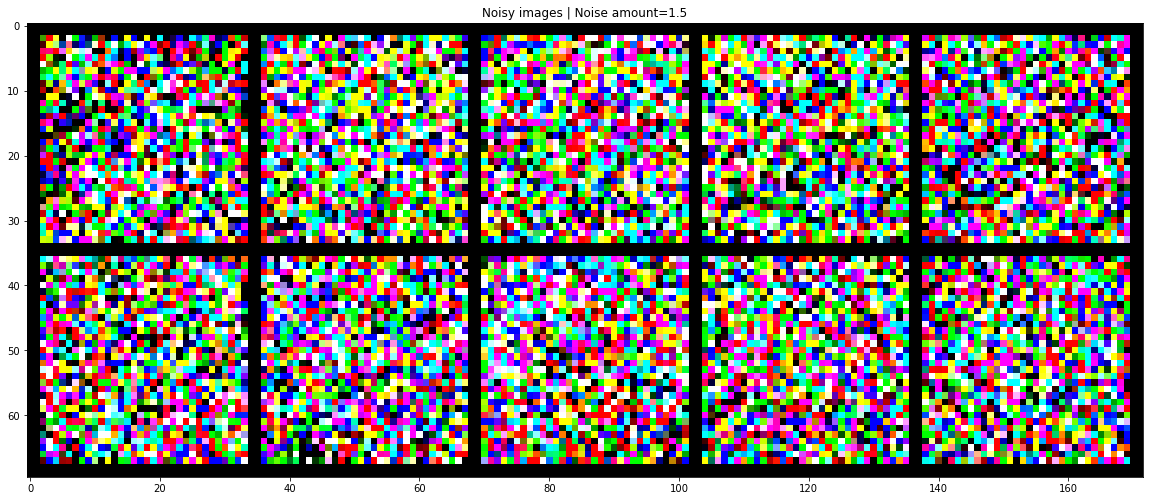

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


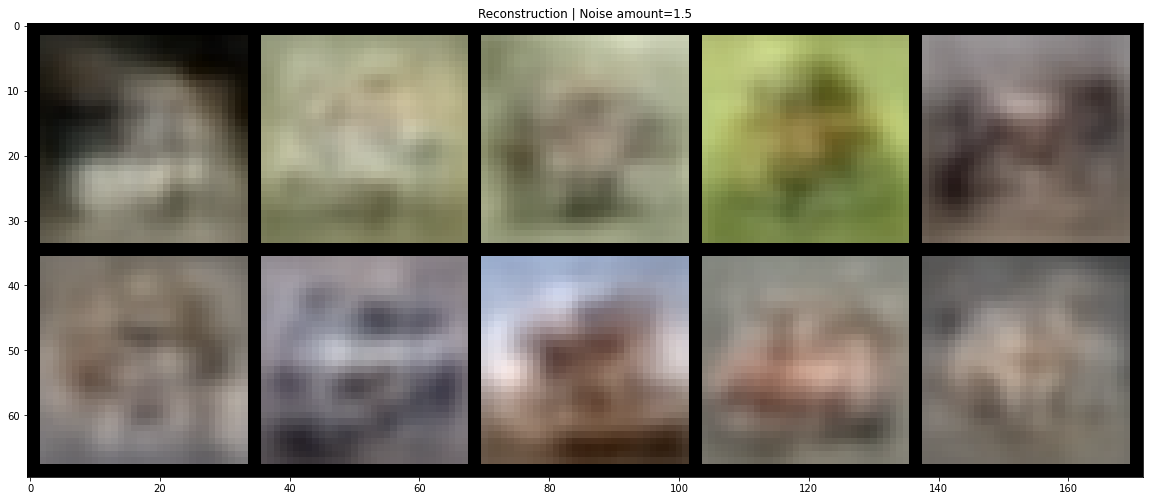

Noise amount: 3.0
Checkpoints found ['../../scratch_link/Foundational-SDM/wandb_Logger/3.0Interpretable_NoCosine_Adam_lr0.0001_datas=None_10000Neurons_projM=False_nlayers1/version_None/checkpoints/epoch=999-step=49000.ckpt']
Load from checkpoint ../../scratch_link/Foundational-SDM/wandb_Logger/3.0Interpretable_NoCosine_Adam_lr0.0001_datas=None_10000Neurons_projM=False_nlayers1/version_None/checkpoints/epoch=999-step=49000.ckpt /home/tbricken/SDM-Diffusion/notebooks
activity threshold is: 0.0


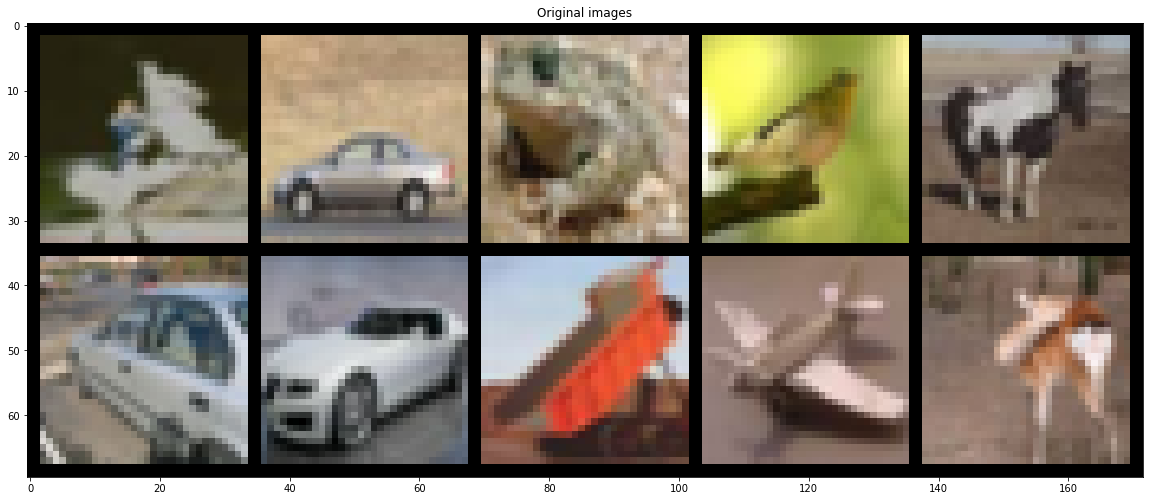

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


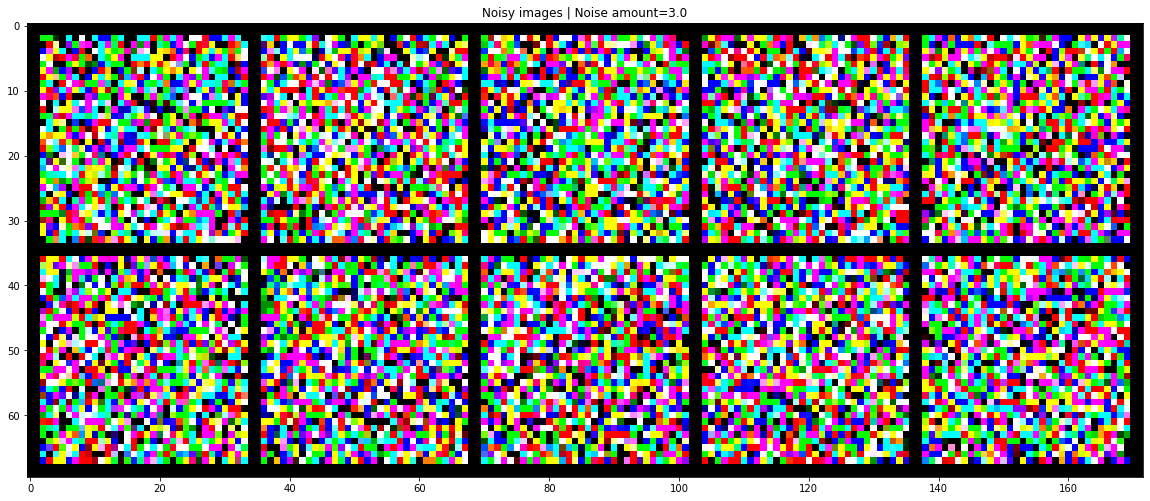

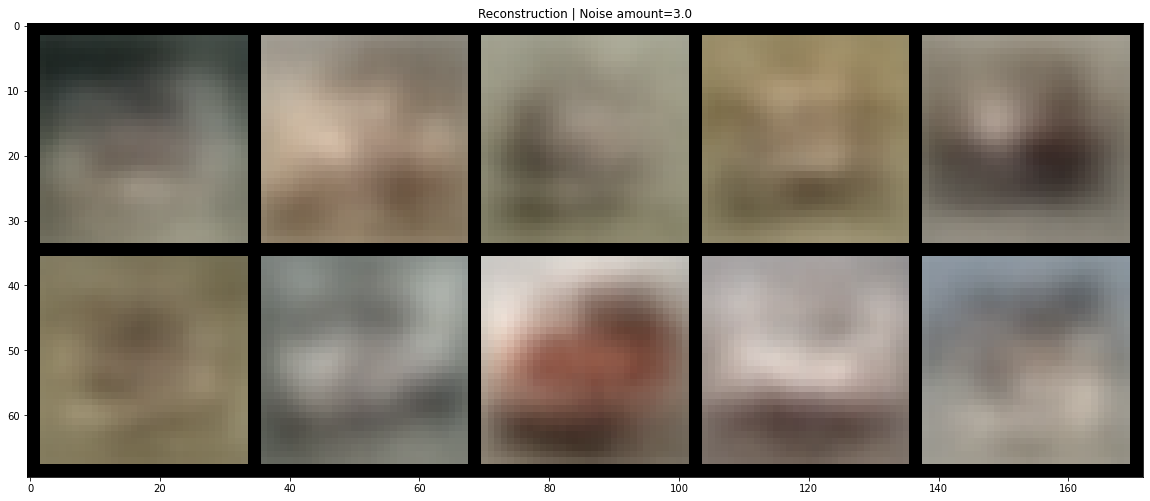

In [28]:

#run = 0.3
bs = 10

#LowerLR
model_template = "SuperLongClassif_Adam_lr0.0001_datas=None_10000Neurons_projM=False_nlayers1"
#"Interpretable_NoCosine_Adam_lr0.0001_datas=None_10000Neurons_projM=False_nlayers1"
#"_ffnCIFAR10_w_Projections_Adam_lr0.0001_datas=None_10000Neurons_projM=True_nlayers1"
#"_ffnRaw_CIFAR10_Adam_lr0.0001_datas=None_10000Neurons_projM=False_nlayers1" #"_ffnRaw_CIFAR10_Adam_lr1e-05_datas=None_10000Neurons_projM=False_nlayers1"#"_ffnBaseline_Adam_lr0.0001_datas=None_1steps_10000Neurons_projM=False_nlayers1"

use_CIFAR10 = True 

model_prefixes = [0.1,0.3,0.8,1.5, 3.0]#["100N","1_000N","10_000N","100_000N"]

dataset_path="../data/"
save_dir = "../../scratch_link/Foundational-SDM/data/CachedLatents/"
extra = {"use_wandb":False}

train_o_test = "test"

if "CIFAR10" in model_template or use_CIFAR10: 
    latent, labels = torch.load(f'../data/CIFAR10/all_data_{train_o_test}.pt')
    latent = latent.flatten(start_dim=1 )
    if latent.dtype is torch.uint8:#"/ImageNet32/" in self.dataset_path or "/CIFAR10/" in self.dataset_path:
            latent = latent.type(torch.float)/255
else: 

    latent, labels = torch.load(f'../data/CachedOutputs/ConvMixerWTransforms_ImgNet32_CIFAR10/all_data_{train_o_test}.pt')

weighted_cosine_sims =[]

rand_inds = np.random.choice(len(latent), bs)


to_plot = []

for run_ind, run in enumerate(model_prefixes): 
    print("Noise amount:", run)

    model, params = load_model(f"{run}{model_template}", dataset_path, save_dir, device, extra_extras=extra)

    if run_ind ==0:
        print(model)

    #######
    
    x_noise, x = model.return_noise_and_final_outputs(latent[rand_inds].to(device))

    gridshow( latent[rand_inds].view(bs, 3,32,32), title=f"Original images" )

    if run_ind ==0:
        to_plot.append( latent[rand_inds].view(bs, 3,32,32) )


    if params.use_projection_matrix and params.project_before_noise:
        gridshow( model.net[0](latent[rand_inds].to(device)).view(bs, 3,32,32), title=f"Projected Image | Noise amount={run}" )
        gridshow( min_max_scale(model.net[0](latent[rand_inds].to(device))).view(bs, 3,32,32), title=f"Min Max Scale, Projected Image | Noise amount={run}" )
        
    gridshow( x_noise.view(bs, 3,32,32), title=f"Noisy images | Noise amount={run}" )
    
    if params.classification: 
        preds = torch.argmax(x,dim=1)
        print("Predictions", preds)
    else: 
        gridshow( x.view(bs, 3,32,32), title=f"Reconstruction | Noise amount={run}" )

    to_plot.append( torch.clone( x_noise.view(bs, 3,32,32) ) )
    to_plot.append( torch.clone(x.view(bs, 3,32,32)) )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


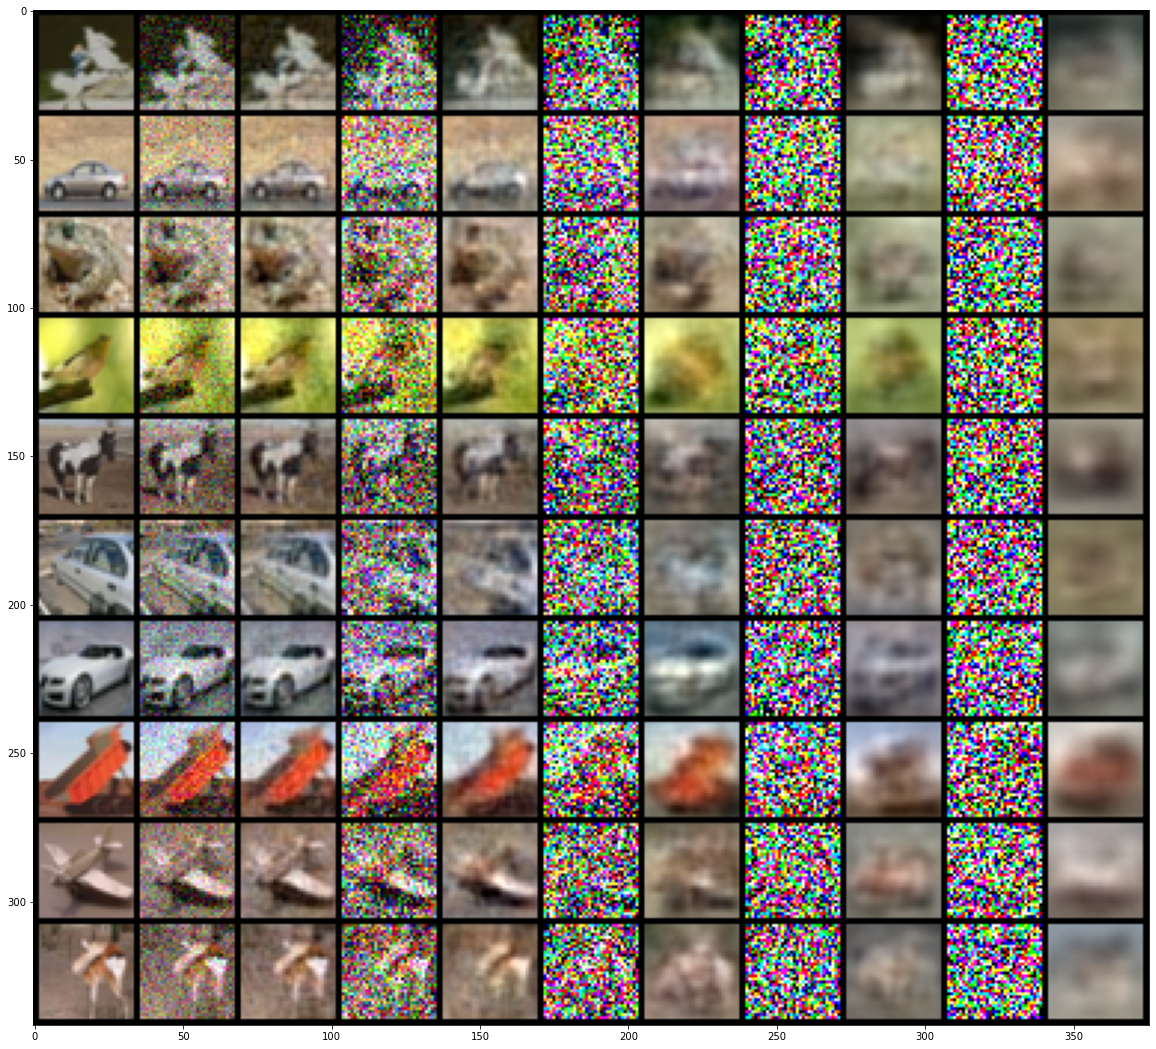

In [29]:
nr = len(model_prefixes)*2 +1
gi= gridshow( torch.stack(to_plot).permute(1,0,2,3,4).reshape(-1, 3,32,32), nrow=nr, save_name="CIFAR10DemoRecons")

In [ ]:
(neuron_active_summer>0.0).sum()

In [ ]:

bs = 10
gridshow( latent[:bs].view(bs, 3,32,32) )
plt.show()

In [ ]:
gridshow( latent[rand_inds].view(bs, 3,32,32), title=f"Original images" )
if params.use_projection_matrix and params.project_before_noise:
    ml = model.net[0](latent[rand_inds].to(device))
    gridshow( ml.view(bs, 3,32,32), title=f"Projected Image | Noise amount={run}" )
    gridshow( min_max_scale(ml).view(bs, 3,32,32), title=f"Min Max Scale, Projected Image | Noise amount={run}" )
gridshow( x_noise.view(bs, 3,32,32), title=f"Noisy images | Noise amount={run}" )

print( ml - x_noise)
gridshow( x.view(bs, 3,32,32), title=f"Reconstruction | Noise amount={run}" )